## Notebook experimenting with different transforms and periodograms to understand underlying periodicity in data

In [7]:
import pandas as pd
import numpy as np
from scipy import stats
import re
import plotly.express as px
import plotly.graph_objects as go
from matplotlib import mlab as mlab
import matplotlib.pyplot as plt
import warnings
import seaborn as sns
from dateutil.parser import parse
import sys
# suppress warnings bc i can
warnings.simplefilter('ignore')
sys.path.insert(0,'/Users/Kathy/Desktop/UW/seaflow/decomposition_project/scripts/')
from tsd_functions import resample_hourly, interp_by_time
from diel_tools import find_night

### Load data

In [8]:
# load the data
all_cruises = pd.read_csv('/Users/Kathy/Desktop/UW/diel_workshop/PSD_mean_2022-10-20.csv')
all_cruises.rename(columns={'date':'time', 'c_quotas':'diam_med'}, inplace=True)
all_cruises = all_cruises.loc[((all_cruises['pop'] == 'prochloro')) | (all_cruises['pop']== 'synecho')]
all_cruises['time'] = pd.DatetimeIndex(all_cruises['time'].apply(lambda x: parse(x))).tz_convert('UTC')

# run for gradient cruise and diel cruise
test_cruises = ['SCOPE_16','MGL1704','KM1906','TN397_740','SCOPE_6']
cruise_list = [all_cruises.loc[all_cruises['cruise']==n] for n in test_cruises]
names = ['G1','G2','G3','G4', 'Diel_2015']

### Fourier Transform <br> 
\begin{equation}   \label{eq:idft-def}
    f_k =  \sum_{j=0}^{N-1} c_j e^{ijk 2\pi/N }, \quad k = 0, \ldots, N-1.
\end{equation} <br>
What is the dominant frequency of our dataset? <br>
Transforming our data into the frequency domain can show us. However, FFT requires all data to be present, so imputation is needed to fill in the gaps. Here, I am using a simple linear interpolation across each population. Additionally, FFT only shows the dominant across the entire cruise. This doesn't take into account the movement of the ship into different environments or populations of organisms.

In [9]:
## let's try running an fft on one population (pro) in g1
g1_hourly_pro = cruise_list[0].loc[cruise_list[0]['pop']=='prochloro']
# interpolate to fill in missing data
g1_hourly_pro_intp = interp_by_time(g1_hourly_pro, 'prochloro')
g1_hourly_pro_diel = find_night(g1_hourly_pro_intp.reset_index())

In [10]:
from scipy.fftpack import fft, ifft, fftfreq, next_fast_len
## FFT the signals
npts = len(g1_hourly_pro_intp)
# fill up by zero padding until 2^N value to speed up the FFT
Nfft = next_fast_len(int(g1_hourly_pro_intp['diam_med'].shape[0])) 
# get time steps (should be 1 hour apart (3600 sec))
time_step=g1_hourly_pro_intp.index.to_series().diff().value_counts().index[0].total_seconds()
# get new frequency vector from FFT
freqVec = fftfreq(Nfft, d=time_step)[:Nfft//2]
# get fourier transform on new size from padded zeros
Zhat = fft(g1_hourly_pro_intp['diam_med'].values,n=Nfft)

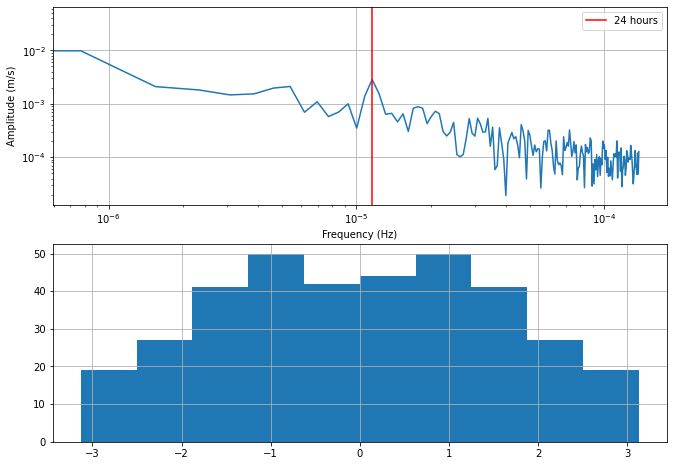

In [11]:
fig,ax=plt.subplots(2,1,figsize=(11,8))
# plot new frequency vector with FFT
ax[0].plot(freqVec,np.abs(Zhat[:Nfft//2])/Nfft)
ax[0].grid(True)
#ax[0].set_ylim(0,0.01)
ax[0].set_xscale('log');ax[0].set_yscale('log')
ax[0].set_xlabel('Frequency (Hz)');ax[0].set_ylabel('Amplitude (m/s)')
# plot where 24H is
ax[0].axvline(x = (1/86400), color = 'r', label='24 hours')
ax[0].legend()
ax[1].hist(np.angle(Zhat))
ax[1].grid(True)

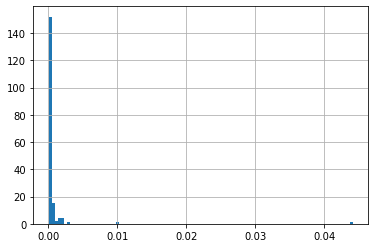

In [12]:
# Plot the histograms of the phase and amplitude spectrum
plt.hist((np.abs(Zhat[:Nfft//2])/Nfft),100);plt.grid(True)
plt.show()

#### Try without zero padding and plotting in hours
(from this [example](https://towardsdatascience.com/fourier-transform-for-time-series-292eb887b101))

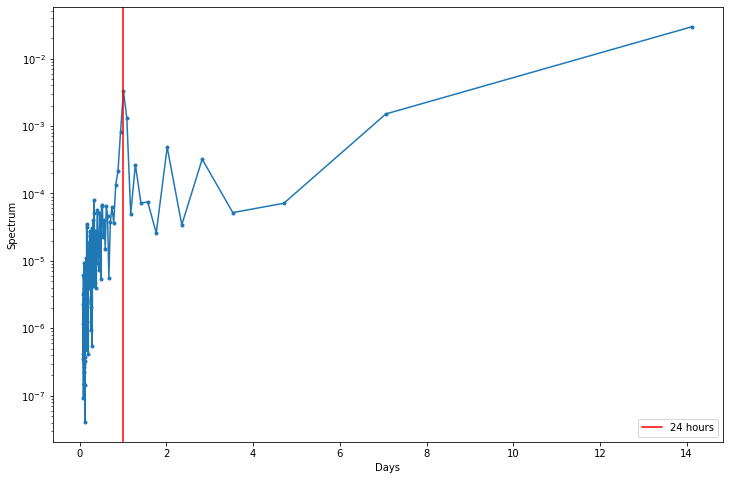

In [13]:
# no zero padding
y=g1_hourly_pro_intp['diam_med'].values
# take absloute value of fft
f=abs(np.fft.fft(y))[:len(y)//2]
# get frequencies
freqVec = fftfreq(len(y), d=time_step)[:len(y)//2]
# get the list of spectrums
spectrum=f.real*f.real+f.imag*f.imag
nspectrum=spectrum/spectrum[0]
# plot in time domain
fig,axs=plt.subplots(figsize=(12,8))
# convert frequency to hours
axs.semilogy((1/freqVec)/86400,nspectrum,marker='.')
# show 24 Hours
axs.axvline(x = 1, color = 'r', label='24 hours')
axs.legend()
axs.set_xlabel("Days")
axs.set_ylabel("Spectrum")
plt.rcParams.update({'font.size':15})

#### Suggestions from Alison
putting confidence limits on freq spectrum <br> 
distinguishing noise v. signal <br> 
cross spectra, ie temp and cell size to see correlations between frequencies
MLD = discssuion point (at least for high frequency stuff)

### Gabor Transform
Looks at where dominant frequencies occur in time with a window function (gaussian distribution) <br>

\begin{equation}   \label{eq:idft-def}
    G_{x}(\tau ,\omega )=\int _{-\infty }^{\infty }x(t)e^{-\pi (t-\tau )^{2}}e^{-j\omega t}\,dt.
\end{equation}

which is basically both the fourier transform and gaussian mashed together

#### Example with simulated data from [tutorial](https://tng-daryl.medium.com/time-series-analysis-obtaining-the-spectrogram-using-the-gabor-transform-ff62c7a9ecb4)

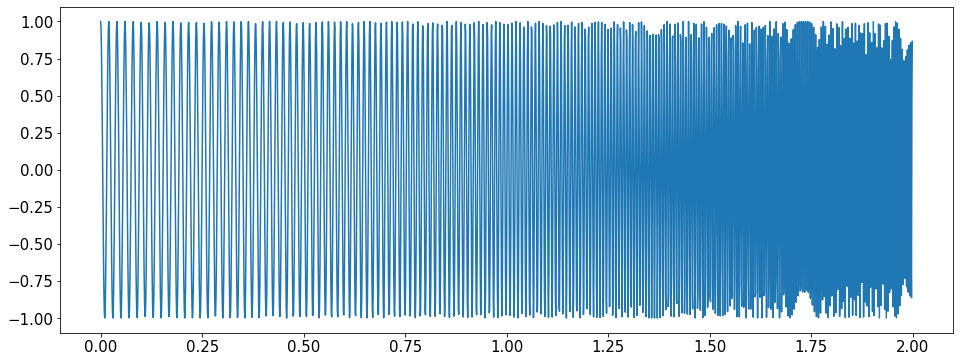

In [14]:
dt = 0.001                #Sampling interval of 0.001 seconds.
t = np.arange(0,2,dt)     #Time duration of 0 to 2.00 seconds
f0 = 50                    #Initial frequency of 50 hz
f1 = 250                   #Final frequency of 250 Hz
t1 = 2                     #Period of time evolving signal = 2 secs
# function with oscillating amplitudes
x = np.cos(2*np.pi*t*(f0 + (f1-f0)*np.power(t,2)/(3*t1**2)))
# first plot function in time domain
fig,axs=plt.subplots(figsize=(16,6))
axs.plot(t,x)

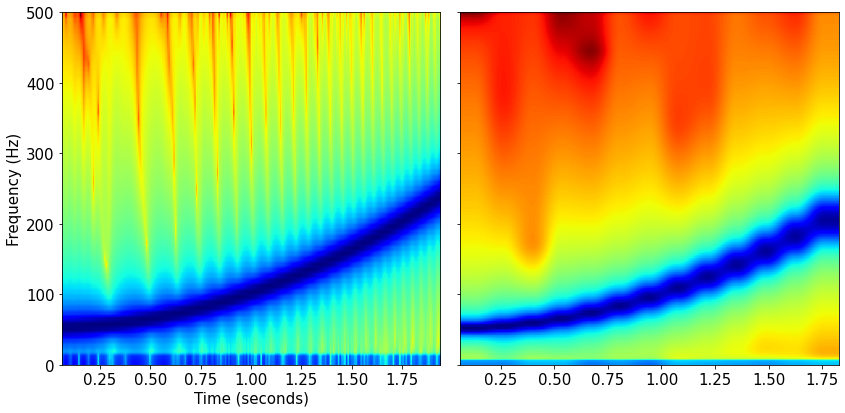

In [15]:
#Sampling frequency of 1 kilohertz, given by (1/period)
fs = 1/dt             
##Plotting the Spectrogram function of the audio signal
fig,axs=plt.subplots(ncols=2,figsize=(12,6),sharey=True)
axs[0].specgram(x, NFFT=128, Fs=1/dt, noverlap=120, cmap='jet_r',detrend='mean')
axs[1].specgram(x, NFFT=256, Fs=1/dt, noverlap=120, cmap='jet_r',detrend='mean')
axs[0].set_xlabel("Time (seconds)")
axs[0].set_ylabel("Frequency (Hz)")
plt.tight_layout()
plt.show()

#### With pro diam data
Shows the detrended short fourier transform boxes run across G1

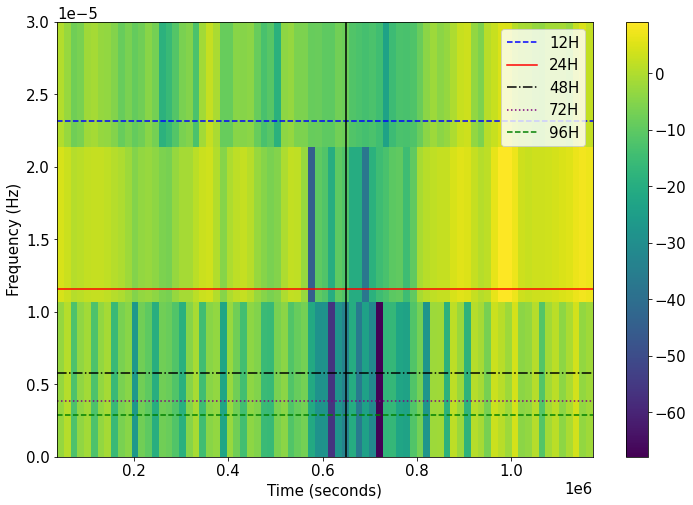

In [16]:
x=g1_hourly_pro_intp['diam_med'].values
dt = 3600                #Sampling interval of every hour (3600 seconds)
t = np.arange(0,len(x)*3600,dt)     #Time duration of 0 to 2.00 seconds
plt.figure(figsize=(12,8))
plt.specgram(x, NFFT=24, Fs=1/dt, noverlap=20, cmap='viridis',detrend='mean')
plt.axis(ymin=0, ymax=0.00003)
# show 24 hour line
plt.axhline(y = 1/(12*3600), color = 'blue', linestyle = '--',label='12H')
plt.axhline(y = 1/(24*3600), color = 'red', linestyle = '-',label='24H')
plt.axhline(y = 1/(48*3600), color = 'k', linestyle = '-.',label='48H')
plt.axhline(y = 1/(72*3600), color = 'purple', linestyle = ':',label='72H')
plt.axhline(y = 1/(96*3600), color = 'green', linestyle = '--',label='96H')
plt.axvline(x=650000, color='k')

plt.legend()
plt.colorbar()
plt.xlabel("Time (seconds)")
plt.ylabel("Frequency (Hz)")
plt.show()

### Lomb-Scargle Periodogram

In [17]:
all_samp = pd.read_feather('/Users/Kathy/Desktop/UW/seaflow/pro_syn_corsize_all.feather')
# remove any lat/lon that are not recorded
all_samp = all_samp[(all_samp['lat'].notnull()) & (all_samp['diam_med'].notnull())]
# take the mean of any replicates
all_samp_uniq = all_samp.groupby(['lat','lon','pop','cruise', 'time']).mean().reset_index()
# take daily average
all_samp_daily = all_samp.groupby([pd.Grouper(key="pop"), pd.Grouper(key="time", freq='24H'), 
                            pd.Grouper(key="cruise")]).mean().reset_index()
all_samp_daily['lat_bins'] = pd.cut(all_samp_daily['lat'], 6).astype(str)
# subset from gradients cruises
gradients = ['KOK1606','MGL1704','KM1906']
g_sizes = all_samp[all_samp['cruise'].isin(gradients)]
g_sizes['biomass'] = g_sizes['Qc_med']*g_sizes['abundance']

# hourly intervals
g_sizes_1H = g_sizes.groupby([pd.Grouper(key="time", freq='1H'), 
                            pd.Grouper(key="cruise"), 'pop']).mean().reset_index()
# get hourly data from each gradients cruise and put in list
g1 = g_sizes_1H[g_sizes_1H['cruise']==gradients[0]]
g2 = g_sizes_1H[g_sizes_1H['cruise']==gradients[1]]
g3 = g_sizes_1H[g_sizes_1H['cruise']==gradients[2]]

In [18]:
import requests
import io
# read in g4
g4 = pd.read_csv('../stats/TN397/SeaFlow_dataset_v1.4_2022-04-19.csv')
# clean up
g4 = g4[g4['lat'].notnull()]
# make dtype ns, UTC
g4['time'] = pd.DatetimeIndex(g4['time'].apply(lambda x: parse(x))).tz_convert('UTC')
# datetimes to utc
#g4['time'] = g4['time'].tz_localize('UTC')
# read par data from sfl
name = 'TN397_740_740.sfl'
url = "https://raw.githubusercontent.com/seaflow-uw/seaflow-sfl/master/curated"
test = f'{url}/{name}'
req = requests.get(test).content
# decode and clean up data
df = pd.read_csv(io.StringIO(req.decode('utf-8')), sep="\t", lineterminator='\n')
df = df[df['LAT'].notnull()][['DATE', 'LAT','LON','SALINITY','PAR','OCEAN TEMP']]

# change column names to match before merge
df.columns= df.columns.str.lower()
df.rename(columns={'date':'time', 'ocean temp': 'temp'}, inplace=True)
# fix time and dtype
df['time'] = pd.DatetimeIndex(df['time'].apply(lambda x: parse(x))).tz_convert('UTC')
# merge with each other
g4_merge=g4.merge(df, on=['time','lat','lon'], how='left')
# melt from wide to long
g4_merge['id'] = g4_merge.index
g4_clean = pd.wide_to_long(g4_merge, stubnames=['abundance', 'diam', 'Qc', 'biomass'],
                sep='_',
                i='id', 
                j='pop',
               suffix='\w+').reset_index().drop(columns=['id']).rename(columns={'diam':'diam_med'})
# summarize by hourly intervals
g4_hourly = g4_clean.groupby([pd.Grouper(key="time", freq='1H'), 
                            pd.Grouper(key="cruise"), 'pop']).mean().reset_index()
# only get pro and syn
pops = ['prochloro', 'synecho', 'picoeuks']
g4_hourly = g4_hourly[g4_hourly['pop'].isin(pops)]
# grab just gradients cruises
g_names = ['G1','G2','G3','G4']
cruises = [g1, g2, g3, g4_hourly]

In [19]:
# loop through each cruise 
for cruise in cruises:
    for pop in pd.unique(cruise['pop']):
        df=resample_hourly(cruise, pop)
        # get time step
        time_step=df.index.to_series().diff().value_counts().index[0].total_seconds()
        # set freq vector

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.02084258300034532 d


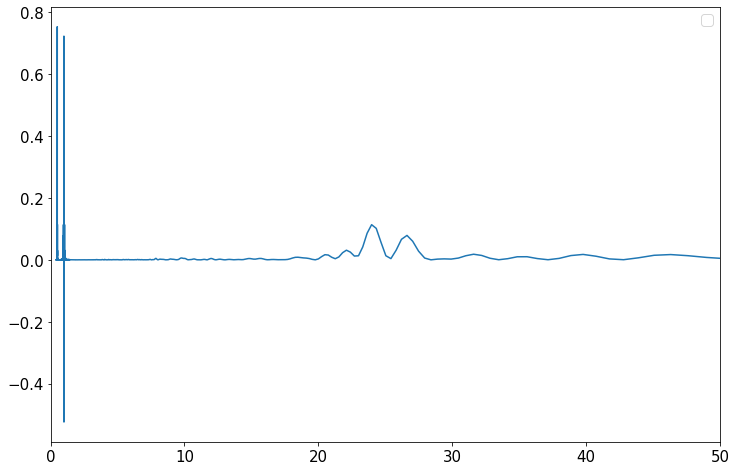

In [20]:
from astropy.time import Time
from astropy.timeseries import LombScargle
## run lombscargle on gradinets data
g1= cruises[0]
#import scipy.signal as signal
#pro=resample_hourly(g1, 'prochloro').reset_index()
pro=g1.loc[(g1['pop']=='prochloro')&(g1['diam_med'].notnull())]
diam = pro['diam_med'].values

tmp_str = pro.iloc[:,0].apply(
        lambda x: parse(str(x)).strftime('%Y-%m-%dT%H:%M:%S')).astype(pd.StringDtype())

t_date = np.array(tmp_str.values,dtype = 'str')
t_date = Time(t_date, format='isot',scale='utc')
#t_date.format = 'mjd'

y = diam
ls = LombScargle(t_date, y)
frequency, power = ls.autopower()

fig, ax=plt.subplots(1,1,figsize=(12,8))
ax.plot((1/frequency)*24,power)
ax.set_xlim((0,50))
# ax.vlines(x=24, ymin=np.min(power),ymax=np.max(power), color='orange', label='24 Hours')
# ax.vlines(x=48, ymin=np.min(power),ymax=np.max(power), color='green', label='48 Hours')
best_period = 1./frequency[np.argmax(power)]
print(best_period)
ax.legend()
plt.show()

In [21]:
ls_df=pd.DataFrame(zip(list(frequency.value),list(power.value)),columns=['freq','power'])
ls_df['period']=(list(1/frequency.value))
ls_df.sort_values(by='power', ascending=False).head(10)

,freq,power,period
3378,47.978698,0.753748,0.020843
3381,48.021302,0.746340,0.020824
3374,47.921893,0.728419,0.020867
3385,48.078107,0.728227,0.020799
1695,24.078107,0.723190,0.041532
1684,23.921893,0.723188,0.041803
5,0.078107,0.722786,12.803030
3373,47.907692,0.695517,0.020873
3386,48.092308,0.695281,0.020793
1696,24.092308,0.690262,0.041507


### Wavelet Transforms